# TACOTRON(Towards End-to-End Speech Synthesis)

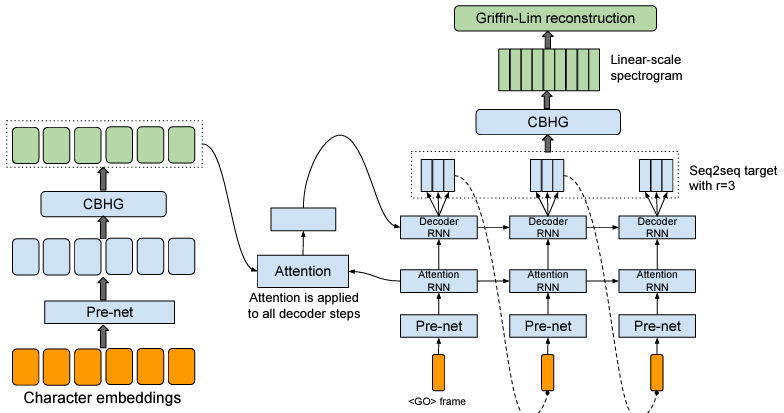



- 인코더: 문장을 Input으로 받아 정보를 추출
- 디코더: 인코더로부터 추출된 정보를 이용하여 멜 스펙토그램을 생성
- 어텐션: 인코더의 정보를 디코더에 매핑
- 후처리: 디코더에서 생성된 멜 스펙토그램을 이용하여 Linear 스펙토그램을 생성

## CBHG
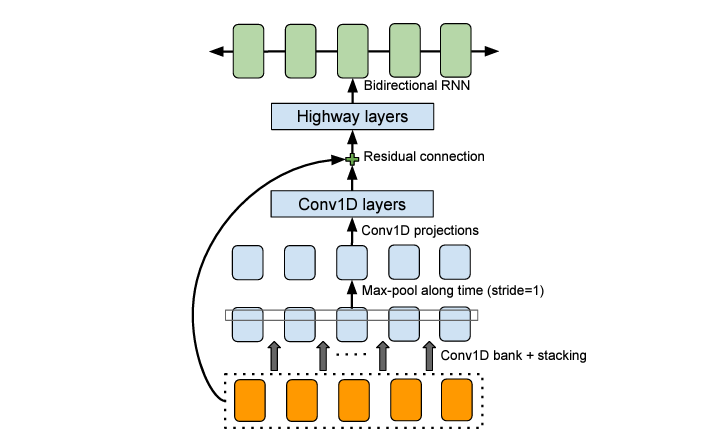
- 인코더와 디코더에 공통적으로 존재
- 순차적인(Sequence) 데이터를 처리하는데 특화
- CBHG 모듈은 1D __C__onvolution __B__ank, __H__ighway 네트워크, Bidirectional __G__RU로 구성
- 모듈은 Sequence 벡터를 Input으로 사용하며 Sequence 벡터가 Output으로 추출



- Sequence 데이터를 1부터 K개의 필터를 갖고 있는 1D Convolution bank에 입력시켜 Feature 벡터를 생성
- Feature 벡터를 Max polling Layer에 통과시켜 Sequence에 따라 변하지 않는 부분(local invariance)을 추출
- 고정된 폭으로 구성된 몇개의 1D Convolution Network을 통과시켜 Sequence 데이터의 벡터 사이즈와 일치하는 벡터를 생성
- Sequence Input데이터와 CNN네트워크의 출력 벡터를 더한다.
- 생성된 벡터를 Highway 네트워크에 통과시켜 high-level features를 생성
- high-level features를 GRU의 입력으로 사용

※ Highway 네트워크는 Gate 구조를 추가한 Residual Connection. 일반적인 Residual Connection은 Input $x$와 함수 $H(x)$가 있을 때 결과 $y$와의 관계를 $y=x+H(x)$로 정의. HighWay 네트워크는 $x$와 $H(x)$을 어느정도 비율로 섞을지를 학습하여 결정할 수 있도록 0에서 1사이의 값을 갖는 $T(x)$를 만들어 $x$와 $H(x)$에 곱한다.

## 인코더(Encoder)
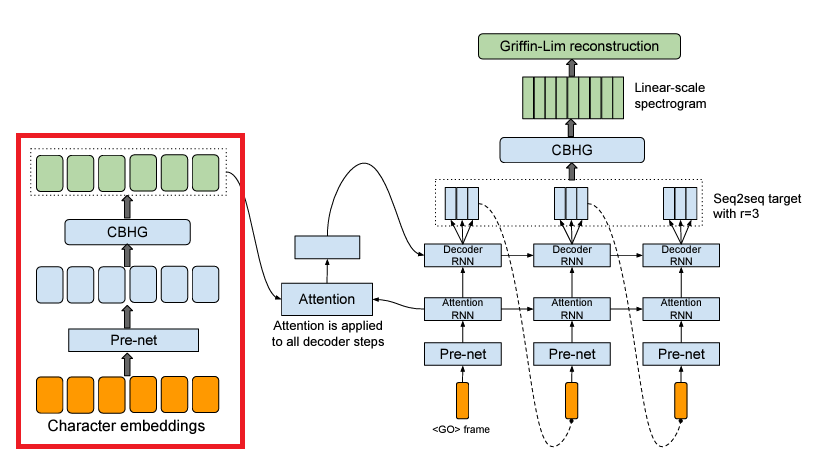

- 임베딩 매트릭스(Embedding Matrix)를 이용하여 One-Hot 벡터로 표현된 캐릭터 Input을 임베딩 벡터로 변환
- FClayer+Lelu+Dropout으로 구성된 Pre-net 모듈에 통과
- Pre-Net의 출력으로 생성된 벡터를 CBHG의 input으로 입력
- CBHG에서 출력된 Sequence 벡터는 어텐션의 인풋으로 사용.

## 디코더(Decoder)
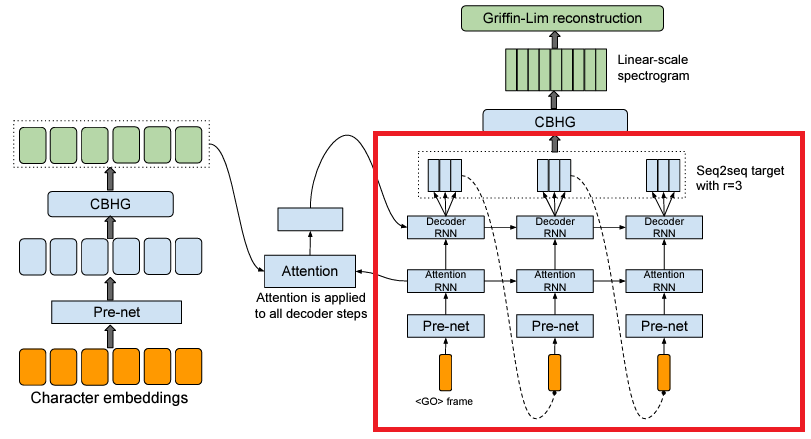

- 디코더는 인코더에서 생성된 Sequence 벡터와 $t-1$ 시점까지 생성된 디코더의 멜 스펙토그램을 Input으로 받아 $t$시점의 멜 스펙토그램을 생성
(처음은 0으로 시작)
- 멜 스펙토그램을 Pre-Net 모듈에 통과시켜 벡터를 생성 한 후 Attention-RNN의 Input으로 사용
- Attention-RNN으로 부터 추출된 Sequence hidden 벡터($d_1$,$d_2$,$d_3$,...,$d_t$)를 query로 이용하여 인코더의 정보를 추출하고 가중합하여 Context 벡터($c_1$,$c_2$,$c_3$,...$c_t$)를 추출
- Attention-RNN hidden 벡터 $d_t$와 Context 벡터 $c_t$를 Concatenate하여 Decoder-RNN의 Input으로 사용
- Decoder-RNN에서 추출된 결과가 디코더의 Output은 $t$시점의 멜 스펙토그램

## 어텐션(Attention)
- [Bahdanau Attetnion](https://medium.com/analytics-vidhya/neural-machine-translation-using-bahdanau-attention-mechanism-d496c9be30c3) 사용.

## Griffin-Lim
- Griffin-Lim 알고리즘은 Linear 스펙트로그램을 음성 신호로 합성하는데 사용하는 알고리즘
- 알고리즘은 특정 모델을 가정하지 않고 음성을 합성할 수 있으며 단순 반복작업을 통하여 음성 신호를 생성하므로 계산량에 있어서 일반적인 보코더보다 유리한 장점을 갖고 있음.

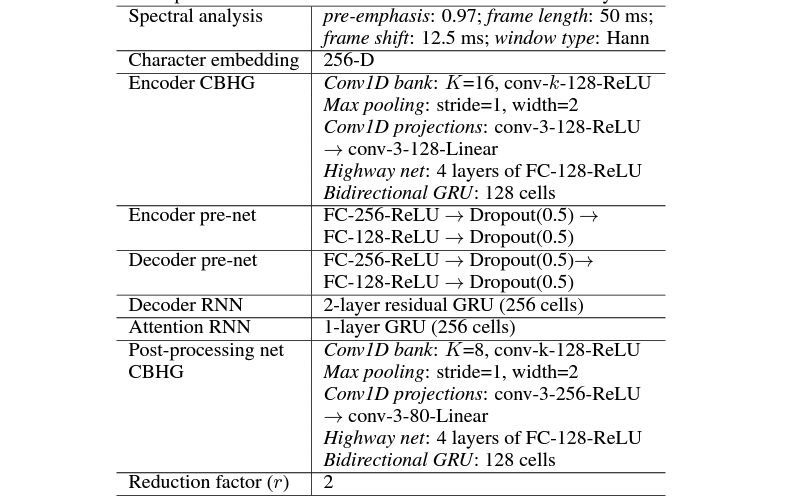

In [1]:
# 한글폰트 설치
!apt-get update -qq
!apt-get install fonts-nanum* -qq
!pip install jamo

Selecting previously unselected package fonts-nanum.
(Reading database ... 155514 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
fm._rebuild()
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'
# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 
mpl.rcParams['axes.unicode_minus'] = False

- 런타임 다시 시작

In [12]:
from jamo import hangul_to_jamo

In [1]:
import os

In [ ]:
#데이터 다운로드
# os.environ을 이용하여 Kaggle API Username, Key 세팅하기
os.environ['KAGGLE_USERNAME'] = 'dpyang22'
os.environ['KAGGLE_KEY'] = 'b83709d16d98397a22a57056b1c1161a'
# Linux 명령어로 Kaggle API를 이용하여 데이터셋 다운로드하기 (!kaggle ~)
# Linux 명령어로 압축 해제하기
!kaggle datasets download -d bryanpark/korean-single-speaker-speech-dataset
!unzip '*.zip'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: kss/4/4_0633.wav        
  inflating: kss/4/4_0634.wav        
  inflating: kss/4/4_0635.wav        
  inflating: kss/4/4_0636.wav        
  inflating: kss/4/4_0637.wav        
  inflating: kss/4/4_0638.wav        
  inflating: kss/4/4_0639.wav        
  inflating: kss/4/4_0640.wav        
  inflating: kss/4/4_0641.wav        
  inflating: kss/4/4_0642.wav        
  inflating: kss/4/4_0643.wav        
  inflating: kss/4/4_0644.wav        
  inflating: kss/4/4_0645.wav        
  inflating: kss/4/4_0646.wav        
  inflating: kss/4/4_0647.wav        
  inflating: kss/4/4_0648.wav        
  inflating: kss/4/4_0649.wav        
  inflating: kss/4/4_0650.wav        
  inflating: kss/4/4_0651.wav        
  inflating: kss/4/4_0652.wav        
  inflating: kss/4/4_0653.wav        
  inflating: kss/4/4_0654.wav        
  inflating: kss/4/4_0655.wav        
  inflating: kss/4/4_0656.wav        
  inflating: kss/4/4_0657.wav        
  inflating: k

In [2]:
max_char = 105
sample_rate = 22050
n_fft = 1024
hop_length = 256
win_length = 1024
preemphasis = 0.97
ref_db = 20
max_db = 100
mel_dim = 80
max_length = 780
reduction = 5
embedding_dim = 256
encoder_dim = 128
decoder_dim = 256
symbol_length = 70
batch_size = 32
batch_group = batch_size * batch_size
checkpoint_step = 2000
max_iter = 200

In [14]:
from jamo import hangul_to_jamo

PAD = '_'
EOS = '~'
SPACE = ' '
# https://liveupdate.tistory.com/149
JAMO_LEADS = "".join([chr(_) for _ in range(0x1100, 0x1113)])
JAMO_VOWELS = "".join([chr(_) for _ in range(0x1161, 0x1176)])
JAMO_TAILS = "".join([chr(_) for _ in range(0x11A8, 0x11C3)])

VALID_CHARS = JAMO_LEADS + JAMO_VOWELS + JAMO_TAILS + SPACE
symbols = PAD + EOS + VALID_CHARS

_symbol_to_id = {s: i for i, s in enumerate(symbols)}
_id_to_symbol = {i: s for i, s in enumerate(symbols)}

def text_to_sequence(text):
  sequence = []
  if not 0x1100 <= ord(text[0]) <= 0x1113:
    text = ''.join(list(hangul_to_jamo(text)))
  for s in text:
    sequence.append(_symbol_to_id[s])
  sequence.append(_symbol_to_id['~'])
  return sequence


def sequence_to_text(sequence):
  result = ''
  for symbol_id in sequence:
    if symbol_id in _id_to_symbol:
      s = _id_to_symbol[symbol_id]
      result += s
  return result.replace('}{', ' ')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
!mkdir Tacotron-pytorch

In [ ]:
%cd /content/

/content


In [ ]:
import pandas as pd
import numpy as np
import os, librosa, re, glob, scipy
from tqdm.notebook import tqdm

text_dir = '/content/transcript.v.1.4.txt'
filters = '([.,!?])'

metadata = pd.read_csv(text_dir, dtype='object', sep='|', header=None)
wav_dir = metadata[0].values
text = metadata[3].values

out_dir = '/content/drive/MyDrive/Tacotron-pytorch'
os.makedirs(out_dir, exist_ok=True)
os.makedirs(out_dir + '/text', exist_ok=True)
os.makedirs(out_dir + '/mel', exist_ok=True)
os.makedirs(out_dir + '/dec', exist_ok=True)
os.makedirs(out_dir + '/spec', exist_ok=True)

# text
print('Load Text')
text_len = []
for idx, s in enumerate(tqdm(text)):
    sentence = re.sub(re.compile(filters), '', s)
    sentence = text_to_sequence(sentence)
    text_len.append(len(sentence))
    text_name = 'kss-text-%05d.npy' % idx
    np.save(os.path.join(out_dir + '/text', text_name), sentence, allow_pickle=False)
np.save(os.path.join(out_dir + '/text_len.npy'), np.array(text_len))
print('Text Done')

# audio
print('Load Audio')
mel_len_list = []

for idx, fn in enumerate(tqdm(wav_dir)):
    file_dir = './kss/'+ fn
    wav, _ = librosa.load(file_dir, sr=sample_rate)
    wav, _ = librosa.effects.trim(wav)
    wav = scipy.signal.lfilter([1, -preemphasis], [1], wav)
    stft = librosa.stft(wav, n_fft=n_fft, hop_length=hop_length, 
                        win_length=win_length)
    
    stft = np.abs(stft)
    mel_filter = librosa.filters.mel(sample_rate, n_fft, mel_dim)
    mel_spec = np.dot(mel_filter, stft)

    mel_spec = 20 * np.log10(np.maximum(1e-5, mel_spec))
    stft = 20 * np.log10(np.maximum(1e-5, stft))

    mel_spec = np.clip((mel_spec - ref_db + max_db) / max_db, 1e-8, 1)
    stft = np.clip((stft - ref_db + max_db) / max_db, 1e-8, 1)

    mel_spec = mel_spec.T.astype(np.float32)
    stft = stft.T.astype(np.float32)
    mel_len_list.append([mel_spec.shape[0], idx])

    # padding
    remainder = mel_spec.shape[0] % reduction
    if remainder != 0:
        mel_spec = np.pad(mel_spec, [[0, reduction - remainder], [0, 0]], 
                          mode='constant')
        stft = np.pad(stft, [[0, reduction - remainder], [0, 0]], 
                      mode='constant')

    mel_name = 'kss-mel-%05d.npy' % idx
    np.save(os.path.join(out_dir + '/mel', mel_name), mel_spec, allow_pickle=False)

    stft_name = 'kss-spec-%05d.npy' % idx
    np.save(os.path.join(out_dir + '/spec', stft_name), stft, allow_pickle=False)

    # Decoder Input
    mel_spec = mel_spec.reshape((-1, mel_dim * reduction))
    dec_input = np.concatenate((np.zeros_like(mel_spec[:1, :]), 
                                mel_spec[:-1, :]), axis=0)
    dec_input = dec_input[:, -mel_dim:]
    dec_name = 'kss-dec-%05d.npy' % idx
    np.save(os.path.join(out_dir + '/dec', dec_name), dec_input, allow_pickle=False)

mel_len = sorted(mel_len_list)
np.save(os.path.join(out_dir + '/mel_len.npy'), np.array(mel_len))
print('Audio Done')    

Load Text


  0%|          | 0/12854 [00:00<?, ?it/s]

Text Done
Load Audio


  0%|          | 0/12854 [00:00<?, ?it/s]

Audio Done


In [4]:
#그래프 함수
import matplotlib

def plot_alignment(alignment, path, text):
    text = text.rstrip('_').rstrip('~')
    alignment = alignment[:len(text)]
    _, ax = plt.subplots(figsize=(len(text)/3, 5))
    ax.imshow(np.transpose(alignment), aspect='auto', origin='lower')
    plt.xlabel('Encoder timestep')
    plt.ylabel('Decoder timestep')
    text = [x if x != ' ' else '' for x in list(text)]
    plt.xticks(range(len(text)), text)
    plt.tight_layout()
    plt.savefig(path, format='png')

## 모델

In [5]:
import torch, librosa
import numpy as np
from torch.nn import Module, Linear, ReLU, Dropout, Conv1d, ModuleList 
from torch.nn import BatchNorm1d, GRU, MaxPool1d, Sigmoid, Softmax, Tanh, Embedding, GRUCell
from copy import deepcopy

class prenet(Module):
    def __init__(self, input_dim):
        super(prenet, self).__init__()
        self.fc1 = Linear(input_dim, embedding_dim)
        self.fc2 = Linear(embedding_dim, encoder_dim)
        
    def forward(self, input_data, is_training):
        x = self.fc1(input_data)
        x = ReLU()(x)
        
        if is_training:
            x = Dropout()(x)
        
        x = self.fc2(x)
        x = ReLU()(x)
        
        if is_training:
            x = Dropout()(x)           
        return x

class CBHG(Module):
    def __init__(self, K, conv_dim):
        super(CBHG, self).__init__()
        self.K = K
        self.conv_bank = ModuleList(
            [Conv1d(conv_dim[1], encoder_dim, kernel_size=k, padding=k//2) for k in range(1, self.K+1)])
        self.bn = BatchNorm1d(encoder_dim)
        
        self.conv1 = Conv1d(encoder_dim * K, conv_dim[0], kernel_size=3, padding=1)
        self.bn1 = BatchNorm1d(conv_dim[0])
        self.conv2 = Conv1d(conv_dim[0], conv_dim[1], kernel_size=3, padding=1)
        self.bn2 = BatchNorm1d(conv_dim[1])
        
        self.fc = Linear(conv_dim[1], encoder_dim)
        self.H = Linear(encoder_dim, encoder_dim)
        self.T = Linear(encoder_dim, encoder_dim)
        self.T.bias.data.fill_(-1)
        
        self.gru = GRU(encoder_dim, encoder_dim, batch_first=True, bidirectional=True)

    def forward(self, input_data, sequence_length):
        maxT = input_data.shape[-1]
        x = torch.cat([ReLU()(self.bn(conv(input_data)[:, :, :maxT])) for conv in self.conv_bank], dim=1)
        x = MaxPool1d(kernel_size=2, stride=1, padding=1)(x)[:, :, :maxT]
        x = ReLU()(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        highway_input = input_data + x
        highway_input = highway_input.transpose(1, 2)

        if self.K == 8:
            highway_input = self.fc(highway_input)
        
        for _ in range(4):
            H = self.H(highway_input)
            H = ReLU()(H)
            T = self.T(highway_input)
            T = Sigmoid()(T)
            highway_input = H * T + highway_input * (1.0 - T)
        x = highway_input

        if sequence_length is not None:
            x = torch.nn.utils.rnn.pack_padded_sequence(x, sequence_length, batch_first=True)
            
        x, _ = self.gru(x)
        
        if sequence_length is not None:
            x, _ = torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True)

        return x

class LuongAttention(Module):
    def __init__(self):
        super(LuongAttention, self).__init__()
        self.w = Linear(decoder_dim, decoder_dim)
        
    def forward(self, query, value):
        alignment = Softmax(dim=-1)(torch.matmul(query, self.w(value).transpose(1, 2)))
        context = torch.matmul(alignment, value)
        context = torch.cat([context, query], axis=-1)
        alignment = alignment.transpose(1, 2)
        return context, alignment

def griffin_lim(spectrogram):
    spec = deepcopy(spectrogram)
    for i in range(50):
        est_wav = librosa.istft(spec, hop_length=hop_length, win_length=win_length)
        est_stft = librosa.stft(est_wav, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
        phase = est_stft / np.maximum(1e-8, np.abs(est_stft))
        spec = spectrogram * phase
    wav = librosa.istft(spec, hop_length=hop_length, win_length=win_length)
    return np.real(wav)

In [6]:
class Encoder(Module):
    def __init__(self, K, conv_dim):
        super(Encoder, self).__init__()
        self.embedding = Embedding(symbol_length, embedding_dim)
        self.prenet = prenet(embedding_dim)
        self.cbhg = CBHG(K, conv_dim)
        
    def forward(self, enc_input, sequence_length, is_training):
        x = self.embedding(enc_input)
        x = self.prenet(x, is_training=is_training)
        x = x.transpose(1, 2)
        x = self.cbhg(x, sequence_length)
        return x

class Decoder(Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.prenet = prenet(mel_dim)
        self.attention_rnn = GRUCell(encoder_dim, decoder_dim)
        self.attention = LuongAttention()
        self.proj1 = Linear(decoder_dim * 2, decoder_dim)
        self.dec_rnn1 = GRUCell(decoder_dim, decoder_dim)
        self.dec_rnn2 = GRUCell(decoder_dim, decoder_dim)
        self.proj2 = Linear(decoder_dim, mel_dim * reduction)

    def forward(self, batch, dec_input, enc_output, mode):
        if mode == 'train':
            dec_input = dec_input.transpose(0, 1)
            attn_rnn_state = torch.zeros(batch, decoder_dim).cuda()
            dec_rnn_state1 = torch.zeros(batch, decoder_dim).cuda()
            dec_rnn_state2 = torch.zeros(batch, decoder_dim).cuda()
        else:
            attn_rnn_state = torch.zeros(batch, decoder_dim)
            dec_rnn_state1 = torch.zeros(batch, decoder_dim)
            dec_rnn_state2 = torch.zeros(batch, decoder_dim)

        iters = dec_input.shape[0] if mode == 'train' else max_iter+1

        
        for i in range(iters):
            inp = dec_input[i] if mode == 'train' else dec_input
            x = self.prenet(inp, is_training=True)
            attn_rnn_state = self.attention_rnn(x, attn_rnn_state)
            attn_rnn_state = attn_rnn_state.unsqueeze(1)
            context, align = self.attention(attn_rnn_state, enc_output)

            dec_rnn_input = self.proj1(context)
            dec_rnn_input = dec_rnn_input.squeeze(1)

            dec_rnn_state1 = self.dec_rnn1(dec_rnn_input, dec_rnn_state1)
            dec_rnn_input = dec_rnn_input + dec_rnn_state1
            dec_rnn_state2 = self.dec_rnn2(dec_rnn_input, dec_rnn_state2)
            dec_rnn_output = dec_rnn_input + dec_rnn_state2

            dec_out = self.proj2(dec_rnn_output)

            dec_out = dec_out.unsqueeze(1)
            attn_rnn_state = attn_rnn_state.squeeze(1)

            if i == 0:
                mel_out = torch.reshape(dec_out, [batch, -1, mel_dim])
                alignment = align
            else:
                mel_out = torch.cat([mel_out, torch.reshape(dec_out, [batch, -1, mel_dim])], dim=1)
                alignment = torch.cat([alignment, align], dim=-1)
                
            if mode == 'inference':
                dec_input = mel_out[:, reduction * (i+1) - 1, :]

        return mel_out, alignment

class Tacotron(Module):
    def __init__(self, K, conv_dim):
        super(Tacotron, self).__init__()
        self.encoder = Encoder(K, conv_dim)
        self.decoder = Decoder()
        
    def forward(self, enc_input, sequence_length, dec_input, is_training, mode):
        batch = dec_input.shape[0]
        x = self.encoder(enc_input, sequence_length, is_training)
        x = self.decoder(batch, dec_input, x, mode)
        return x

class post_CBHG(Module):
    def __init__(self, K, conv_dim):
        super(post_CBHG, self).__init__()
        self.cbhg = CBHG(K, conv_dim)
        self.fc = Linear(256, n_fft // 2 + 1)
        
    def forward(self, mel_input):
        x = self.cbhg(mel_input.transpose(1, 2), None)
        x = self.fc(x)
        return x

In [10]:
import os, argparse, traceback, glob, random, itertools, time, torch, threading, queue
import numpy as np
import torch.optim as optim
from torch.nn import L1Loss
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import easydict


data_dir = '/content/drive/MyDrive/Tacotron-pytorch'
text_list = sorted(glob.glob(os.path.join(data_dir + '/text', '*.npy')))
mel_list = sorted(glob.glob(os.path.join(data_dir + '/mel', '*.npy')))
dec_list = sorted(glob.glob(os.path.join(data_dir + '/dec', '*.npy')))

fn = os.path.join(data_dir + '/mel_len.npy')
if not os.path.isfile(fn):
    mel_len_list = []
    for i in range(len(mel_list)):
        mel_length = np.load(mel_list[i]).shape[0]
        mel_len_list.append([mel_length, i])
    mel_len = sorted(mel_len_list)
    np.save(os.path.join(data_dir + '/mel_len.npy'), np.array(mel_len))

text_len = np.load(os.path.join(data_dir + '/text_len.npy'))
mel_len = np.load(os.path.join(data_dir + '/mel_len.npy'))

def DataGenerator():
    while True:
        idx_list = np.random.choice(len(mel_list), batch_group, replace=False)
        idx_list = sorted(idx_list)
        idx_list = [idx_list[i : i + batch_size] for i in range(0, len(idx_list), batch_size)]
        random.shuffle(idx_list)

        for idx in idx_list:
            random.shuffle(idx)

            text = [torch.from_numpy(np.load(text_list[mel_len[i][1]])) for i in idx]
            dec = [torch.from_numpy(np.load(dec_list[mel_len[i][1]])) for i in idx]
            mel = [torch.from_numpy(np.load(mel_list[mel_len[i][1]])) for i in idx]

            text_length = torch.tensor([text_len[mel_len[i][1]] for i in idx], dtype=torch.int32)
            text_length, _ = text_length.sort(descending=True)

            text = pad_sequence(text, batch_first=True)
            dec = pad_sequence(dec, batch_first=True)
            mel = pad_sequence(mel, batch_first=True)

            yield [text, dec, mel, text_length]

class Generator(threading.Thread):
    def __init__(self, generator):
        threading.Thread.__init__(self)
        self.queue = queue.Queue(8)
        self.generator = generator
        self.start()

    def run(self):
        for item in self.generator:
            self.queue.put(item)
        self.queue.put(None)

    def next(self):
        next_item = self.queue.get()
        if next_item is None:
             raise StopIteration
        return next_item

def train(args):
    train_loader = Generator(DataGenerator())
    model = Tacotron(K=16, conv_dim=[128, 128]).cuda()
    optimizer = optim.Adam(model.parameters())
    step, epochs = 0, 0
    if args.checkpoint is not None:
        ckpt = torch.load(args.checkpoint)
        model.load_state_dict(ckpt['model'])
        optimizer.load_state_dict(ckpt['optimizer'])
        step = ckpt['step'],
        step = step[0]
        epoch = ckpt['epoch']
        print('Load Status: Epoch %d, Step %d' % (epoch, step))

    torch.backends.cudnn.benchmark = True

    try:
        for epoch in itertools.count(epochs):
            for _ in range(batch_group):
                start = time.time()
                text, dec, target, text_length = train_loader.next()
                text = text.cuda()
                dec = dec.float().cuda()
                target = target.float().cuda()

                pred, alignment = model(text, text_length, dec, is_training=True, mode='train')
                loss = L1Loss()(pred, target)

                model.zero_grad()
                loss.backward()
                optimizer.step()    

                step += 1
                print('step: {}, loss: {:.5f}, {:.3f} sec/step'.format(step, loss, time.time() - start))

                if step % checkpoint_step == 0:
                    save_dir = '/content/drive/MyDrive/Tacotron-pytorch/ckpt/' + args.name + '/1'
                    
                    input_seq = sequence_to_text(text[0].cpu().numpy())
                    input_seq = input_seq[:text_length[0].cpu().numpy()]
                    alignment_dir = os.path.join(save_dir, 'step-{}-align.png'.format(str(step)))
                    plot_alignment(alignment[0].detach().cpu().numpy(), alignment_dir, input_seq)
                    torch.save({
                        'model': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'step': step,
                        'epoch': epoch
                    }, os.path.join(save_dir, 'ckpt-{}.pt'.format(str(step))))

    except Exception as e:
        traceback.print_exc()

args = easydict.EasyDict({
    # 예)'/content/ckpt/checkpoint/1/ckpt-12000.pt'
    "checkpoint": None,  # 이어서 학습할때는 체크포인트 경로로 변경 그렇지 않으면 'None'
    "name": 'checkpoint1',
})
save_dir = os.path.join('/content/drive/MyDrive/Tacotron-pytorch/ckpt/' + args.name, '1')
os.makedirs(save_dir, exist_ok=True)
train(args)

step: 1, loss: 0.23227, 65.320 sec/step
step: 2, loss: 0.20230, 119.942 sec/step
step: 3, loss: 0.17429, 21.381 sec/step
step: 4, loss: 0.16514, 18.801 sec/step
step: 5, loss: 0.15378, 18.071 sec/step
step: 6, loss: 0.14173, 19.247 sec/step
step: 7, loss: 0.13559, 18.083 sec/step
step: 8, loss: 0.13638, 19.171 sec/step
step: 9, loss: 0.12598, 19.823 sec/step
step: 10, loss: 0.12803, 18.802 sec/step
step: 11, loss: 0.13014, 17.138 sec/step
step: 12, loss: 0.11729, 19.854 sec/step
step: 13, loss: 0.11702, 18.308 sec/step
step: 14, loss: 0.11582, 19.375 sec/step
step: 15, loss: 0.11165, 16.731 sec/step
step: 16, loss: 0.10839, 20.330 sec/step
step: 17, loss: 0.10488, 17.158 sec/step
step: 18, loss: 0.10336, 20.621 sec/step
step: 19, loss: 0.10313, 17.989 sec/step
step: 20, loss: 0.09983, 21.695 sec/step
step: 21, loss: 0.10218, 17.635 sec/step
step: 22, loss: 0.09997, 20.594 sec/step
step: 23, loss: 0.08836, 20.536 sec/step
step: 24, loss: 0.10546, 15.951 sec/step
step: 25, loss: 0.10163,

KeyboardInterrupt: ignored

In [ ]:
# 할당받은 GPU 뭔지 알수있는 코드 (예: Tesla P100)
import os
GPU_NAME = os.popen('nvidia-smi --query-gpu=name --format=csv,noheader').read().strip()
os.environ['GPU_NAME'] = GPU_NAME
print(f'GPU: {GPU_NAME}')

GPU: Tesla P100-PCIE-16GB


## post_CBHG

In [ ]:
data_dir = '/content/drive/MyDrive/Tacotron-pytorch'
mel_list = sorted(glob.glob(os.path.join(data_dir + '/mel', '*.npy')))
spec_list = sorted(glob.glob(os.path.join(data_dir + '/spec', '*.npy')))
mel_len = np.load(os.path.join(data_dir + '/mel_len.npy'))

def DataGenerator():
    while True:
        idx_list = np.random.choice(len(mel_list), batch_group, replace=False)
        idx_list = sorted(idx_list)
        idx_list = [idx_list[i : i + batch_size] for i in range(0, len(idx_list), batch_size)]
        random.shuffle(idx_list)

        for idx in idx_list:
            random.shuffle(idx)

            mel = [torch.from_numpy(np.load(mel_list[mel_len[i][1]])) for i in idx]
            spec = [torch.from_numpy(np.load(spec_list[mel_len[i][1]])) for i in idx]

            mel = pad_sequence(mel, batch_first=True)
            spec = pad_sequence(spec, batch_first=True)

            yield [mel, spec]

class Generator(threading.Thread):
    def __init__(self, generator):
        threading.Thread.__init__(self)
        self.queue = queue.Queue(8)
        self.generator = generator
        self.start()

    def run(self):
        for item in self.generator:
            self.queue.put(item)
        self.queue.put(None)

    def next(self):
        next_item = self.queue.get()
        if next_item is None:
             raise StopIteration
        return next_item

def train(args):
    train_loader = Generator(DataGenerator())

    model = post_CBHG(K=8, conv_dim=[256, mel_dim]).cuda()

    optimizer = optim.Adam(model.parameters())

    step, epochs = 0, 0
    if args.checkpoint is not None:
        ckpt = torch.load(args.checkpoint)
        model.load_state_dict(ckpt['model'])
        optimizer.load_state_dict(ckpt['optimizer'])
        step = ckpt['step'],
        step = step[0]
        epoch = ckpt['epoch']
        print(f'Load Status: Epoch {epoch}, step {step}')

    torch.backends.cudnn.benchmark = True
    try:
        for epoch in itertools.count(epochs):
            for _ in range(batch_group):
                start = time.time()
                mel, target = train_loader.next()
                mel = mel.float().cuda()
                target = target.float().cuda()

                pred = model(mel)
                loss = L1Loss()(pred, target)

                model.zero_grad()
                loss.backward()
                optimizer.step()

                step += 1
                print(f'step: {step}, loss: {loss:.5f}, {(time.time()-start):.3f} sec/step')

                if step % checkpoint_step == 0:
                    save_dir = '/content/drive/MyDrive/Tacotron-pytorch/ckpt/' \
                               + args.name + '/2'
                    torch.save({
                        'model': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'step': step,
                        'epoch': epoch
                    }, os.path.join(save_dir, f'ckpt-{step}.pt'))

    except Exception as e:
        traceback.print_exc()

args = easydict.EasyDict({
    "checkpoint": None,
    "name": 'checkpoint1',
})
save_dir = os.path.join('/content/drive/MyDrive/Tacotron-pytorch/ckpt' + args.name, '2')
os.makedirs(save_dir, exist_ok=True)
train(args)

Load Status: Epoch 5, Step 6000
step: 6001, loss: 0.04085, 0.104 sec/step
step: 6002, loss: 0.03578, 0.119 sec/step
step: 6003, loss: 0.04240, 0.083 sec/step
step: 6004, loss: 0.04191, 0.065 sec/step
step: 6005, loss: 0.04186, 0.078 sec/step
step: 6006, loss: 0.04045, 0.102 sec/step
step: 6007, loss: 0.04124, 0.070 sec/step
step: 6008, loss: 0.04094, 0.060 sec/step
step: 6009, loss: 0.04090, 0.092 sec/step
step: 6010, loss: 0.04069, 0.099 sec/step
step: 6011, loss: 0.04031, 0.051 sec/step
step: 6012, loss: 0.04140, 0.055 sec/step
step: 6013, loss: 0.04120, 0.061 sec/step
step: 6014, loss: 0.04103, 0.065 sec/step
step: 6015, loss: 0.04056, 0.068 sec/step
step: 6016, loss: 0.04118, 0.055 sec/step
step: 6017, loss: 0.04075, 0.050 sec/step
step: 6018, loss: 0.04049, 0.063 sec/step
step: 6019, loss: 0.04010, 0.059 sec/step
step: 6020, loss: 0.03913, 0.050 sec/step
step: 6021, loss: 0.03979, 0.054 sec/step
step: 6022, loss: 0.04150, 0.058 sec/step
step: 6023, loss: 0.04243, 0.060 sec/step
st

KeyboardInterrupt: ignored

## 체크포인트 다운로드

In [ ]:
'/content/drive/MyDrive/SeSAC_배포용 폴더/학습자료/dataset/tacotrin_ckpt-42000.pt'
'/content/drive/MyDrive/SeSAC_배포용 폴더/학습자료/dataset/post_CBHG_ckpt-16000.pt'

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4370 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4449 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4467 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4527 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4352 missing from current font.
  font.set_text(s

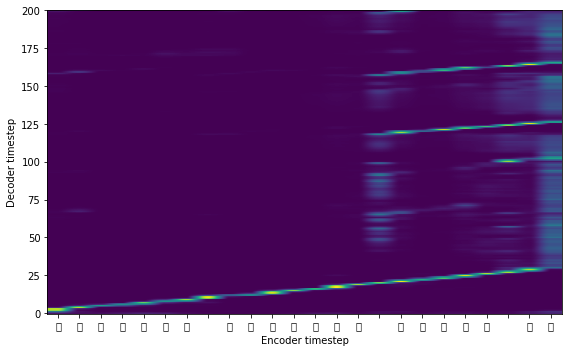

In [17]:
import matplotlib.pyplot as plt

save_dir = './output'
os.makedirs(save_dir, exist_ok=True)

def taco_inference(text, idx):
    seq = text_to_sequence(text)
    enc_input = torch.tensor(seq, dtype=torch.int64).unsqueeze(0)
    sequence_length = torch.tensor([len(seq)], dtype=torch.int32)
    dec_input = torch.from_numpy(np.zeros((1, mel_dim), dtype=np.float32))

    pred, alignment = model(enc_input, sequence_length, dec_input,
                            is_training=False, mode='inference')
    pred = pred.squeeze().detach().numpy()
    alignment = np.squeeze(alignment.detach().numpy(), axis=0)

    np.save(os.path.join(save_dir, f'mel-{idx}'), pred, allow_pickle=False)

    input_seq = sequence_to_text(seq)
    alignment_dir = os.path.join(save_dir, f'align-{idx}.png')
    plot_alignment(alignment, alignment_dir, input_seq)

sentences = [
             '하늘과 바람과 별과 시'
]

model = Tacotron(K=16, conv_dim=[128,128])
ckpt = torch.load('/content/drive/MyDrive/SeSAC_배포용 폴더/학습자료/dataset/tacotrin_ckpt-42000.pt')
model.load_state_dict(ckpt['model'])

for i, text in enumerate(sentences):
    jamo = ''.join(list(hangul_to_jamo(text)))
    taco_inference(jamo, i)    

In [21]:
import soundfile as sf
import scipy
import IPython.display as ipd

mel_list = glob.glob(os.path.join(save_dir, '*.npy'))

def CBHG_inference(text, idx):
    mel = torch.from_numpy(text).unsqueeze(0)
    pred = model(mel)
    pred = pred.squeeze().detach().numpy()
    pred = np.transpose(pred)

    pred = (np.clip(pred, 0, 1) * max_db) - max_db + ref_db
    pred = np.power(10.0, pred * 0.05)

    wav = griffin_lim(pred ** 1.5)
    wav = scipy.signal.lfilter([1], [1, -preemphasis], wav)
    wav = librosa.effects.trim(wav, frame_length=win_length, hop_length=hop_length)[0]
    wav = wav.astype(np.float32)

    sf.write(os.path.join(save_dir, f'{idx}.wav'), wav, sample_rate)
    ipd.Audio(wav, rate=sample_rate)

model = post_CBHG(K=8, conv_dim=[256, mel_dim])
ckpt = torch.load('/content/drive/MyDrive/SeSAC_배포용 폴더/학습자료/dataset/post_CBHG_ckpt-16000.pt')
model.load_state_dict(ckpt['model'])

for i, fn in enumerate(mel_list):
    mel = np.load(fn)
    CBHG_inference(mel, i)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4364 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4453 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4358 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4449 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4527 missing from current font.
  font.set_text(s

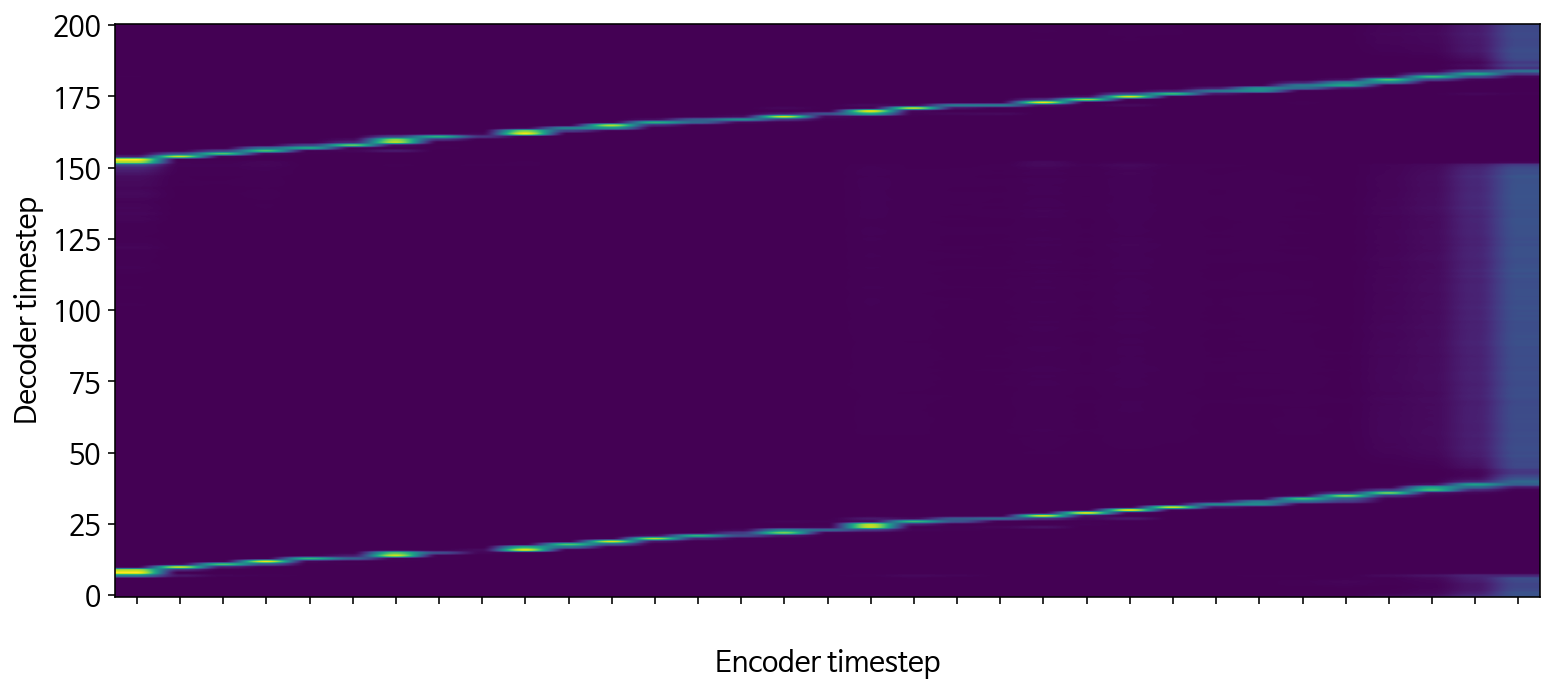